Assumed missing values --> Living Area, Bedrooms, Furnished, Surface of the plot, Building condition, Kitchen type, Terrace, Garden, Frontages

Discarded variables --> Tenement Building, Swimming Pool, Fireplaces

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pgeocode
from sklearn.preprocessing import OrdinalEncoder


%reload_ext autoreload
%autoreload 2

In [59]:
df = pd.read_csv('data/unclean_data.csv')
df

,Immoweb ID,Property type,property sub-type,Price,Post code,Building condition,Kitchen type,Bedrooms,Furnished,Terrace surface,Tenement building,Number of frontages,Swimming pool,How many fireplaces?,Garden,Terrace,Surface of the plot,Living area,Garden surface,Garden orientation
0,9729720,APARTMENT,PENTHOUSE,179000,1140,Good,Semi equipped,1.0,Yes,9.0,No,NaN,NaN,NaN,NaN,NaN,NaN,63.0,NaN,NaN
1,9729785,APARTMENT,PENTHOUSE,255000,8370,Good,Installed,1.0,Yes,46.0,No,2.0,NaN,NaN,NaN,NaN,NaN,42.0,NaN,NaN
2,9729784,APARTMENT,PENTHOUSE,255000,8370,Good,Installed,1.0,Yes,46.0,No,2.0,NaN,NaN,NaN,NaN,NaN,42.0,NaN,NaN
3,9729780,APARTMENT,PENTHOUSE,620000,8370,Good,Installed,3.0,Yes,70.0,No,2.0,NaN,NaN,NaN,NaN,NaN,150.0,NaN,NaN
4,9727201,APARTMENT,PENTHOUSE,379000,1020,Good,USA hyper equipped,2.0,No,110.0,No,3.0,No,NaN,NaN,NaN,NaN,120.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14536,7770552,APARTMENT,SERVICE_FLAT,132000,1730,As new,NaN,1.0,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14537,7770553,APARTMENT,SERVICE_FLAT,177000,1730,As new,NaN,1.0,NaN,NaN,No,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN
14538,7770551,APARTMENT,SERVICE_FLAT,190000,1730,As new,NaN,2.0,NaN,NaN,No,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN
14539,7921693,APARTMENT,SERVICE_FLAT,1350000,5600,NaN,NaN,30.0,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,1500.0,NaN,NaN


### Remove Null Price rows and change type to float

In [60]:
df = df[pd.to_numeric(df['Price'], errors='coerce').notnull()]

In [61]:
df = df.astype({"Price": float}, errors='raise')

### Remove duplicate ID

In [62]:
df['Immoweb ID'].value_counts()

9691876    4
9662650    3
9597143    3
8237073    3
9687272    3
          ..
9623733    1
9245768    1
9606238    1
9695276    1
7921699    1
Name: Immoweb ID, Length: 13893, dtype: int64

In [63]:
df = df.drop_duplicates(['Immoweb ID'], keep='last')
df['Immoweb ID'].value_counts()

9729720    1
9678715    1
9697071    1
9557609    1
9678634    1
          ..
9518030    1
9622950    1
9478102    1
9620790    1
7921699    1
Name: Immoweb ID, Length: 13893, dtype: int64

### Remove subtype 

In [64]:
df = df[df['property sub-type'] != "APARTMENT_BLOCK"]
df['property sub-type'].value_counts()

VILLA                   2468
GROUND_FLOOR            1606
DUPLEX                  1580
MIXED_USE_BUILDING      1240
PENTHOUSE               1170
FLAT_STUDIO              873
EXCEPTIONAL_PROPERTY     566
SERVICE_FLAT             500
MANSION                  479
TOWN_HOUSE               383
COUNTRY_COTTAGE          292
LOFT                     271
BUNGALOW                 212
FARMHOUSE                171
TRIPLEX                   99
KOT                       95
CHALET                    94
MANOR_HOUSE               62
CASTLE                    50
Name: property sub-type, dtype: int64

### Building condition

In [8]:
df['Building condition'].value_counts()
df['Building condition'].unique()

array(['Good', nan, 'As new', 'To renovate', 'To be done up',
       'Just renovated', 'To restore'], dtype=object)

In [65]:
building_condition_map = {'As new': 6, 'Just renovated': 5, 'Good': 4, 'To be done up': 3, 'To renovate':2, 'To restore':1}
df = df.applymap(lambda s: building_condition_map.get(s) if s in building_condition_map else s)

In [10]:
df['Building condition'].isnull().sum()

3828

In [66]:
df['Building condition'] = df['Building condition'].fillna(2)
df['Building condition'].isnull().sum()

0

### Living area

#### Fill missing values in Living area row

In [67]:
def fill_living_area(col):  
    if col['Living area'] > 0:
        return col['Living area']
    else: 
        if col['Property type'] == 'APARTMENT':
            return 95.0
        else:
            return 150.0


df['Living area'] = df.apply(lambda col: fill_living_area(col), axis=1)


In [68]:
# Test if there are null values in living area
df['Living area'].isnull().sum()

0

### Add City Column

In [75]:
nomi = pgeocode.Nominatim('be')
#nomi.query_postal_code('1040')['community_name']

def get_city(col):
    return nomi.query_postal_code(col['Post code'])['community_name']

df['City'] = df.apply(lambda col: get_city(col), axis=1)

In [76]:
df

,Immoweb ID,Property type,property sub-type,Price,Post code,Building condition,Kitchen type,Bedrooms,Furnished,Terrace surface,...,Number of frontages,Swimming pool,How many fireplaces?,Garden,Terrace,Surface of the plot,Living area,Garden surface,Garden orientation,City
0,9729720,APARTMENT,PENTHOUSE,179000.0,1140,4.0,Semi equipped,1.0,Yes,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,63.0,NaN,NaN,Arrondissement Brussel-Hoofdstad
1,9729785,APARTMENT,PENTHOUSE,255000.0,8370,4.0,Installed,1.0,Yes,46.0,...,2.0,NaN,NaN,NaN,NaN,NaN,42.0,NaN,NaN,Brugge
2,9729784,APARTMENT,PENTHOUSE,255000.0,8370,4.0,Installed,1.0,Yes,46.0,...,2.0,NaN,NaN,NaN,NaN,NaN,42.0,NaN,NaN,Brugge
3,9729780,APARTMENT,PENTHOUSE,620000.0,8370,4.0,Installed,3.0,Yes,70.0,...,2.0,NaN,NaN,NaN,NaN,NaN,150.0,NaN,NaN,Brugge
4,9727201,APARTMENT,PENTHOUSE,379000.0,1020,4.0,USA hyper equipped,2.0,No,110.0,...,3.0,No,NaN,NaN,NaN,NaN,120.0,NaN,NaN,Arrondissement Brussel-Hoofdstad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14536,7770552,APARTMENT,SERVICE_FLAT,132000.0,1730,6.0,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,95.0,NaN,NaN,Halle-Vilvoorde
14537,7770553,APARTMENT,SERVICE_FLAT,177000.0,1730,6.0,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,Yes,NaN,95.0,NaN,NaN,Halle-Vilvoorde
14538,7770551,APARTMENT,SERVICE_FLAT,190000.0,1730,6.0,NaN,2.0,NaN,NaN,...,NaN,NaN,NaN,NaN,Yes,NaN,95.0,NaN,NaN,Halle-Vilvoorde
14539,7921693,APARTMENT,SERVICE_FLAT,1350000.0,5600,2.0,NaN,30.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1500.0,NaN,NaN,Philippeville


### One Hot Encoding of Property type, property sub-type, Post code, City

In [77]:
df = pd.get_dummies(df, columns=['Property type', 'property sub-type', 'Post code', 'City'])

df

,Immoweb ID,Price,Building condition,Kitchen type,Bedrooms,Furnished,Terrace surface,Tenement building,Number of frontages,Swimming pool,...,City_Soignies,City_Thuin,City_Tielt,City_Tongeren,City_Tournai,City_Turnhout,City_Verviers,City_Veurne,City_Virton,City_Waremme
0,9729720,179000.0,4.0,Semi equipped,1.0,Yes,9.0,No,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,9729785,255000.0,4.0,Installed,1.0,Yes,46.0,No,2.0,NaN,...,0,0,0,0,0,0,0,0,0,0
2,9729784,255000.0,4.0,Installed,1.0,Yes,46.0,No,2.0,NaN,...,0,0,0,0,0,0,0,0,0,0
3,9729780,620000.0,4.0,Installed,3.0,Yes,70.0,No,2.0,NaN,...,0,0,0,0,0,0,0,0,0,0
4,9727201,379000.0,4.0,USA hyper equipped,2.0,No,110.0,No,3.0,No,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14536,7770552,132000.0,6.0,NaN,1.0,NaN,NaN,No,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
14537,7770553,177000.0,6.0,NaN,1.0,NaN,NaN,No,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
14538,7770551,190000.0,6.0,NaN,2.0,NaN,NaN,No,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
14539,7921693,1350000.0,2.0,NaN,30.0,NaN,NaN,No,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


### Kitchen type	


In [78]:
Kit_type_dict = {"USA uninstalled" : 0, 
                 "Not installed" : 0, 
                 "Installed": 1, 
                 "USA installed": 1,
                 "Semi equipped": 1,
                 "USA semi equipped": 1,
                 "Hyper equipped": 2,
                 "USA hyper equipped": 2
                }

df = df.replace(Kit_type_dict)
df["Kitchen type"] = df["Kitchen type"].fillna(0)


df

,Immoweb ID,Price,Building condition,Kitchen type,Bedrooms,Furnished,Terrace surface,Tenement building,Number of frontages,Swimming pool,...,City_Soignies,City_Thuin,City_Tielt,City_Tongeren,City_Tournai,City_Turnhout,City_Verviers,City_Veurne,City_Virton,City_Waremme
0,9729720,179000.0,4.0,1.0,1.0,Yes,9.0,No,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,9729785,255000.0,4.0,1.0,1.0,Yes,46.0,No,2.0,NaN,...,0,0,0,0,0,0,0,0,0,0
2,9729784,255000.0,4.0,1.0,1.0,Yes,46.0,No,2.0,NaN,...,0,0,0,0,0,0,0,0,0,0
3,9729780,620000.0,4.0,1.0,3.0,Yes,70.0,No,2.0,NaN,...,0,0,0,0,0,0,0,0,0,0
4,9727201,379000.0,4.0,2.0,2.0,No,110.0,No,3.0,No,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14536,7770552,132000.0,6.0,0.0,1.0,NaN,NaN,No,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
14537,7770553,177000.0,6.0,0.0,1.0,NaN,NaN,No,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
14538,7770551,190000.0,6.0,0.0,2.0,NaN,NaN,No,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
14539,7921693,1350000.0,2.0,0.0,30.0,NaN,NaN,No,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


### Furnished


In [79]:
df['Furnished'].unique()

array(['Yes', 'No', nan], dtype=object)

In [80]:
df['Furnished'].isnull().sum()

4080

#### fill No to missing value then map to 1,0

In [81]:
df['Furnished'] = df['Furnished'].fillna("No")
df['Furnished'] = df['Furnished'].apply(lambda v: 0 if v == "No" else 1)

#### double check if value is 1, 0 and no missing value

In [82]:
print(df['Furnished'].unique())
print(df['Furnished'].isna().sum())

[1 0]
0


### Bedrooms


In [83]:
# Fill missing values with 2 bedrooms
df['Bedrooms'] = df['Bedrooms'].fillna(2).astype(int)

df["Bedrooms"].value_counts()

2      4389
3      2929
4      1723
1      1350
5       909
6       429
7       144
8       126
10       61
9        49
12       21
11       20
14       11
13        8
18        7
16        5
17        5
15        5
30        4
25        3
23        3
50        2
60        1
204       1
20        1
22        1
28        1
27        1
35        1
24        1
Name: Bedrooms, dtype: int64

### Terrace surface + Terrace	


#### Combine terrace & terrace surface in yes and no

In [84]:
df['Terrace_Combined'] = np.where(df['Terrace surface'].isnull() & df['Terrace'].isnull(), 'No', 'Yes')

#### Transform Terrace_Combined to 0 & 1

In [85]:
terrace = ['No', 'Yes']

ordenc = OrdinalEncoder(categories=[terrace])

df[["Terrace_Combined"]] = ordenc.fit_transform(df[["Terrace_Combined"]])

df

,Immoweb ID,Price,Building condition,Kitchen type,Bedrooms,Furnished,Terrace surface,Tenement building,Number of frontages,Swimming pool,...,City_Thuin,City_Tielt,City_Tongeren,City_Tournai,City_Turnhout,City_Verviers,City_Veurne,City_Virton,City_Waremme,Terrace_Combined
0,9729720,179000.0,4.0,1.0,1,1,9.0,No,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1.0
1,9729785,255000.0,4.0,1.0,1,1,46.0,No,2.0,NaN,...,0,0,0,0,0,0,0,0,0,1.0
2,9729784,255000.0,4.0,1.0,1,1,46.0,No,2.0,NaN,...,0,0,0,0,0,0,0,0,0,1.0
3,9729780,620000.0,4.0,1.0,3,1,70.0,No,2.0,NaN,...,0,0,0,0,0,0,0,0,0,1.0
4,9727201,379000.0,4.0,2.0,2,0,110.0,No,3.0,No,...,0,0,0,0,0,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14536,7770552,132000.0,6.0,0.0,1,0,NaN,No,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0.0
14537,7770553,177000.0,6.0,0.0,1,0,NaN,No,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1.0
14538,7770551,190000.0,6.0,0.0,2,0,NaN,No,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1.0
14539,7921693,1350000.0,2.0,0.0,30,0,NaN,No,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0.0


#### Drop Terrace and Terrace Surface columns

In [86]:
df = df.drop(columns =['Terrace', 'Terrace surface'])

df

,Immoweb ID,Price,Building condition,Kitchen type,Bedrooms,Furnished,Tenement building,Number of frontages,Swimming pool,How many fireplaces?,...,City_Thuin,City_Tielt,City_Tongeren,City_Tournai,City_Turnhout,City_Verviers,City_Veurne,City_Virton,City_Waremme,Terrace_Combined
0,9729720,179000.0,4.0,1.0,1,1,No,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1.0
1,9729785,255000.0,4.0,1.0,1,1,No,2.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1.0
2,9729784,255000.0,4.0,1.0,1,1,No,2.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1.0
3,9729780,620000.0,4.0,1.0,3,1,No,2.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1.0
4,9727201,379000.0,4.0,2.0,2,0,No,3.0,No,NaN,...,0,0,0,0,0,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14536,7770552,132000.0,6.0,0.0,1,0,No,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0.0
14537,7770553,177000.0,6.0,0.0,1,0,No,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1.0
14538,7770551,190000.0,6.0,0.0,2,0,No,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1.0
14539,7921693,1350000.0,2.0,0.0,30,0,No,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0.0


### ~~Tenement building	~~


In [87]:
df = df.drop(columns =['Tenement building'])

df

,Immoweb ID,Price,Building condition,Kitchen type,Bedrooms,Furnished,Number of frontages,Swimming pool,How many fireplaces?,Garden,...,City_Thuin,City_Tielt,City_Tongeren,City_Tournai,City_Turnhout,City_Verviers,City_Veurne,City_Virton,City_Waremme,Terrace_Combined
0,9729720,179000.0,4.0,1.0,1,1,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1.0
1,9729785,255000.0,4.0,1.0,1,1,2.0,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1.0
2,9729784,255000.0,4.0,1.0,1,1,2.0,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1.0
3,9729780,620000.0,4.0,1.0,3,1,2.0,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1.0
4,9727201,379000.0,4.0,2.0,2,0,3.0,No,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14536,7770552,132000.0,6.0,0.0,1,0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0.0
14537,7770553,177000.0,6.0,0.0,1,0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1.0
14538,7770551,190000.0,6.0,0.0,2,0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1.0
14539,7921693,1350000.0,2.0,0.0,30,0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0.0


### Swimming pool	


In [88]:
# Fill missing values with value 0
df['Swimming pool'].fillna(0, inplace = True)
df['Swimming pool'] = df['Swimming pool'].apply(lambda v: 0 if v == "No" else 1)
df['Swimming pool'].isnull().sum()

0

In [89]:
df['Swimming pool'].unique()

array([1, 0])

### Garden + Garden surface	


In [90]:
print(df['Garden'].isna().sum())
print(df['Garden'].unique())

11051
[nan 'Yes']


In [91]:
df.loc[df['Garden surface'].isna()]

,Immoweb ID,Price,Building condition,Kitchen type,Bedrooms,Furnished,Number of frontages,Swimming pool,How many fireplaces?,Garden,...,City_Thuin,City_Tielt,City_Tongeren,City_Tournai,City_Turnhout,City_Verviers,City_Veurne,City_Virton,City_Waremme,Terrace_Combined
0,9729720,179000.0,4.0,1.0,1,1,NaN,1,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1.0
1,9729785,255000.0,4.0,1.0,1,1,2.0,1,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1.0
2,9729784,255000.0,4.0,1.0,1,1,2.0,1,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1.0
3,9729780,620000.0,4.0,1.0,3,1,2.0,1,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1.0
4,9727201,379000.0,4.0,2.0,2,0,3.0,0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14536,7770552,132000.0,6.0,0.0,1,0,NaN,1,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0.0
14537,7770553,177000.0,6.0,0.0,1,0,NaN,1,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1.0
14538,7770551,190000.0,6.0,0.0,2,0,NaN,1,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1.0
14539,7921693,1350000.0,2.0,0.0,30,0,NaN,1,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0.0


#### Combine ['Garden'] and ['Garden surface] as ['garden_label] and map to 1,0

In [92]:
def categorise(col):  
    if col['Garden'] == "Yes" or col['Garden surface'] > 0:
        return 1
    return 0


df['garden_label'] = df.apply(lambda col: categorise(col), axis=1)

#### double check if value is 1, 0 and no missing value

In [93]:
df['garden_label'].unique()

array([0, 1])

#### drop column Garden and Garden surface

In [94]:
df = df.drop(columns =['Garden', 'Garden surface'])

df

,Immoweb ID,Price,Building condition,Kitchen type,Bedrooms,Furnished,Number of frontages,Swimming pool,How many fireplaces?,Surface of the plot,...,City_Tielt,City_Tongeren,City_Tournai,City_Turnhout,City_Verviers,City_Veurne,City_Virton,City_Waremme,Terrace_Combined,garden_label
0,9729720,179000.0,4.0,1.0,1,1,NaN,1,NaN,NaN,...,0,0,0,0,0,0,0,0,1.0,0
1,9729785,255000.0,4.0,1.0,1,1,2.0,1,NaN,NaN,...,0,0,0,0,0,0,0,0,1.0,0
2,9729784,255000.0,4.0,1.0,1,1,2.0,1,NaN,NaN,...,0,0,0,0,0,0,0,0,1.0,0
3,9729780,620000.0,4.0,1.0,3,1,2.0,1,NaN,NaN,...,0,0,0,0,0,0,0,0,1.0,0
4,9727201,379000.0,4.0,2.0,2,0,3.0,0,NaN,NaN,...,0,0,0,0,0,0,0,0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14536,7770552,132000.0,6.0,0.0,1,0,NaN,1,NaN,NaN,...,0,0,0,0,0,0,0,0,0.0,0
14537,7770553,177000.0,6.0,0.0,1,0,NaN,1,NaN,NaN,...,0,0,0,0,0,0,0,0,1.0,0
14538,7770551,190000.0,6.0,0.0,2,0,NaN,1,NaN,NaN,...,0,0,0,0,0,0,0,0,1.0,0
14539,7921693,1350000.0,2.0,0.0,30,0,NaN,1,NaN,NaN,...,0,0,0,0,0,0,0,0,0.0,0


### ~~Garden orientation~~


#### Drop garden orientation

In [95]:
df = df.drop(columns =['Garden orientation'])

df

,Immoweb ID,Price,Building condition,Kitchen type,Bedrooms,Furnished,Number of frontages,Swimming pool,How many fireplaces?,Surface of the plot,...,City_Tielt,City_Tongeren,City_Tournai,City_Turnhout,City_Verviers,City_Veurne,City_Virton,City_Waremme,Terrace_Combined,garden_label
0,9729720,179000.0,4.0,1.0,1,1,NaN,1,NaN,NaN,...,0,0,0,0,0,0,0,0,1.0,0
1,9729785,255000.0,4.0,1.0,1,1,2.0,1,NaN,NaN,...,0,0,0,0,0,0,0,0,1.0,0
2,9729784,255000.0,4.0,1.0,1,1,2.0,1,NaN,NaN,...,0,0,0,0,0,0,0,0,1.0,0
3,9729780,620000.0,4.0,1.0,3,1,2.0,1,NaN,NaN,...,0,0,0,0,0,0,0,0,1.0,0
4,9727201,379000.0,4.0,2.0,2,0,3.0,0,NaN,NaN,...,0,0,0,0,0,0,0,0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14536,7770552,132000.0,6.0,0.0,1,0,NaN,1,NaN,NaN,...,0,0,0,0,0,0,0,0,0.0,0
14537,7770553,177000.0,6.0,0.0,1,0,NaN,1,NaN,NaN,...,0,0,0,0,0,0,0,0,1.0,0
14538,7770551,190000.0,6.0,0.0,2,0,NaN,1,NaN,NaN,...,0,0,0,0,0,0,0,0,1.0,0
14539,7921693,1350000.0,2.0,0.0,30,0,NaN,1,NaN,NaN,...,0,0,0,0,0,0,0,0,0.0,0


### ~~How many fireplaces?	~~


#### Discard fireplaces

In [96]:
df = df.drop(columns =["How many fireplaces?"])

df

,Immoweb ID,Price,Building condition,Kitchen type,Bedrooms,Furnished,Number of frontages,Swimming pool,Surface of the plot,Living area,...,City_Tielt,City_Tongeren,City_Tournai,City_Turnhout,City_Verviers,City_Veurne,City_Virton,City_Waremme,Terrace_Combined,garden_label
0,9729720,179000.0,4.0,1.0,1,1,NaN,1,NaN,63.0,...,0,0,0,0,0,0,0,0,1.0,0
1,9729785,255000.0,4.0,1.0,1,1,2.0,1,NaN,42.0,...,0,0,0,0,0,0,0,0,1.0,0
2,9729784,255000.0,4.0,1.0,1,1,2.0,1,NaN,42.0,...,0,0,0,0,0,0,0,0,1.0,0
3,9729780,620000.0,4.0,1.0,3,1,2.0,1,NaN,150.0,...,0,0,0,0,0,0,0,0,1.0,0
4,9727201,379000.0,4.0,2.0,2,0,3.0,0,NaN,120.0,...,0,0,0,0,0,0,0,0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14536,7770552,132000.0,6.0,0.0,1,0,NaN,1,NaN,95.0,...,0,0,0,0,0,0,0,0,0.0,0
14537,7770553,177000.0,6.0,0.0,1,0,NaN,1,NaN,95.0,...,0,0,0,0,0,0,0,0,1.0,0
14538,7770551,190000.0,6.0,0.0,2,0,NaN,1,NaN,95.0,...,0,0,0,0,0,0,0,0,1.0,0
14539,7921693,1350000.0,2.0,0.0,30,0,NaN,1,NaN,1500.0,...,0,0,0,0,0,0,0,0,0.0,0


### Surface of the plot




In [97]:
# Fill empty values with 0
df['Surface of the plot'].fillna(0, inplace = True)

### Frontages

In [98]:
df['Number of frontages'].isnull().sum()

3927

In [99]:
#get ['number of frontages'] with values and calc mean
selected_rows = df[~df['Number of frontages'].isnull()]
mean_num_of_frontages = selected_rows['Number of frontages'].mean(axis=0).round(0)
mean_num_of_frontages

3.0

In [100]:
# fill mean value to missing value
df['Number of frontages'] = df['Number of frontages'].fillna(mean_num_of_frontages)
df['Number of frontages'].isnull().sum()

0

In [101]:
df['Number of frontages'] = df['Number of frontages'].astype(int)

In [102]:
# double check
df['Number of frontages'].value_counts()

3     5260
4     3504
2     3346
1       91
6        6
7        2
5        1
16       1
Name: Number of frontages, dtype: int64

### Final check missing value %




In [103]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
missing_value_df

,column_name,percent_missing
Immoweb ID,Immoweb ID,0.0
Price,Price,0.0
Building condition,Building condition,0.0
Kitchen type,Kitchen type,0.0
Bedrooms,Bedrooms,0.0
...,...,...
City_Veurne,City_Veurne,0.0
City_Virton,City_Virton,0.0
City_Waremme,City_Waremme,0.0
Terrace_Combined,Terrace_Combined,0.0


In [104]:
df.columns.to_list()

['Immoweb ID',
 'Price',
 'Building condition',
 'Kitchen type',
 'Bedrooms',
 'Furnished',
 'Number of frontages',
 'Swimming pool',
 'Surface of the plot',
 'Living area',
 'Property type_APARTMENT',
 'Property type_HOUSE',
 'property sub-type_BUNGALOW',
 'property sub-type_CASTLE',
 'property sub-type_CHALET',
 'property sub-type_COUNTRY_COTTAGE',
 'property sub-type_DUPLEX',
 'property sub-type_EXCEPTIONAL_PROPERTY',
 'property sub-type_FARMHOUSE',
 'property sub-type_FLAT_STUDIO',
 'property sub-type_GROUND_FLOOR',
 'property sub-type_KOT',
 'property sub-type_LOFT',
 'property sub-type_MANOR_HOUSE',
 'property sub-type_MANSION',
 'property sub-type_MIXED_USE_BUILDING',
 'property sub-type_PENTHOUSE',
 'property sub-type_SERVICE_FLAT',
 'property sub-type_TOWN_HOUSE',
 'property sub-type_TRIPLEX',
 'property sub-type_VILLA',
 'Post code_1000',
 'Post code_1020',
 'Post code_1030',
 'Post code_1040',
 'Post code_1050',
 'Post code_1060',
 'Post code_1070',
 'Post code_1080',
 'Post

## Outliers

### Bedrooms

#### Boxplot

<AxesSubplot:xlabel='Bedrooms'>

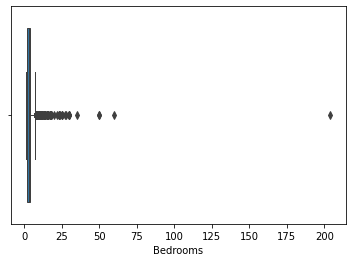

In [105]:
sns.boxplot(x='Bedrooms', data=df, width=0.8, linewidth=1)

#### Drop all properties with more than 25 bedrooms

In [106]:
df.drop(df[df['Bedrooms'] > 25].index, inplace = True)

In [107]:
df

,Immoweb ID,Price,Building condition,Kitchen type,Bedrooms,Furnished,Number of frontages,Swimming pool,Surface of the plot,Living area,...,City_Tielt,City_Tongeren,City_Tournai,City_Turnhout,City_Verviers,City_Veurne,City_Virton,City_Waremme,Terrace_Combined,garden_label
0,9729720,179000.0,4.0,1.0,1,1,3,1,0.0,63.0,...,0,0,0,0,0,0,0,0,1.0,0
1,9729785,255000.0,4.0,1.0,1,1,2,1,0.0,42.0,...,0,0,0,0,0,0,0,0,1.0,0
2,9729784,255000.0,4.0,1.0,1,1,2,1,0.0,42.0,...,0,0,0,0,0,0,0,0,1.0,0
3,9729780,620000.0,4.0,1.0,3,1,2,1,0.0,150.0,...,0,0,0,0,0,0,0,0,1.0,0
4,9727201,379000.0,4.0,2.0,2,0,3,0,0.0,120.0,...,0,0,0,0,0,0,0,0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14535,9463953,204760.0,2.0,0.0,1,0,3,1,0.0,95.0,...,0,0,0,0,0,0,0,0,0.0,0
14536,7770552,132000.0,6.0,0.0,1,0,3,1,0.0,95.0,...,0,0,0,0,0,0,0,0,0.0,0
14537,7770553,177000.0,6.0,0.0,1,0,3,1,0.0,95.0,...,0,0,0,0,0,0,0,0,1.0,0
14538,7770551,190000.0,6.0,0.0,2,0,3,1,0.0,95.0,...,0,0,0,0,0,0,0,0,1.0,0


### Living Area

#### Boxplot

<AxesSubplot:xlabel='Living area'>

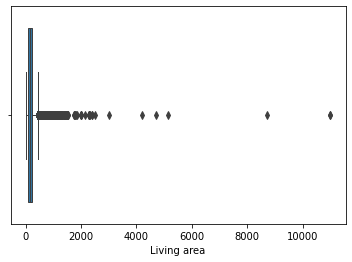

In [108]:
sns.boxplot(x='Living area', data=df, width=0.8, linewidth=1)

In [109]:
df[df['Living area'] > 2500]

,Immoweb ID,Price,Building condition,Kitchen type,Bedrooms,Furnished,Number of frontages,Swimming pool,Surface of the plot,Living area,...,City_Tielt,City_Tongeren,City_Tournai,City_Turnhout,City_Verviers,City_Veurne,City_Virton,City_Waremme,Terrace_Combined,garden_label
6273,9711495,2300000.0,4.0,1.0,8,0,4,1,50000.0,11000.0,...,0,0,0,0,0,0,0,1,0.0,0
6275,9475248,2300000.0,4.0,1.0,8,0,4,1,50000.0,11000.0,...,0,0,0,0,0,0,0,1,0.0,0
7706,9702571,645000.0,4.0,2.0,4,0,4,1,0.0,4198.0,...,0,0,0,0,0,0,0,0,1.0,1
9032,9626629,935000.0,2.0,0.0,4,0,4,1,5000.0,8700.0,...,0,0,0,0,0,0,0,1,1.0,1
12944,9619982,1040000.0,6.0,0.0,9,0,4,0,5128.0,5128.0,...,0,0,0,0,0,0,0,0,0.0,0
12980,9641913,2817145.0,4.0,0.0,3,0,3,1,3602.0,3000.0,...,1,0,0,0,0,0,0,0,0.0,0
13218,9459870,2550000.0,2.0,0.0,2,0,4,1,0.0,2520.0,...,0,0,0,0,0,0,0,0,0.0,0
13980,9514696,2350000.0,4.0,0.0,2,0,4,1,8500.0,4700.0,...,0,0,1,0,0,0,0,0,0.0,1


#### Drop all properties with Living area more than 2500

In [110]:
df.drop(df[df['Living area'] > 2500].index, inplace = True)

df

,Immoweb ID,Price,Building condition,Kitchen type,Bedrooms,Furnished,Number of frontages,Swimming pool,Surface of the plot,Living area,...,City_Tielt,City_Tongeren,City_Tournai,City_Turnhout,City_Verviers,City_Veurne,City_Virton,City_Waremme,Terrace_Combined,garden_label
0,9729720,179000.0,4.0,1.0,1,1,3,1,0.0,63.0,...,0,0,0,0,0,0,0,0,1.0,0
1,9729785,255000.0,4.0,1.0,1,1,2,1,0.0,42.0,...,0,0,0,0,0,0,0,0,1.0,0
2,9729784,255000.0,4.0,1.0,1,1,2,1,0.0,42.0,...,0,0,0,0,0,0,0,0,1.0,0
3,9729780,620000.0,4.0,1.0,3,1,2,1,0.0,150.0,...,0,0,0,0,0,0,0,0,1.0,0
4,9727201,379000.0,4.0,2.0,2,0,3,0,0.0,120.0,...,0,0,0,0,0,0,0,0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14535,9463953,204760.0,2.0,0.0,1,0,3,1,0.0,95.0,...,0,0,0,0,0,0,0,0,0.0,0
14536,7770552,132000.0,6.0,0.0,1,0,3,1,0.0,95.0,...,0,0,0,0,0,0,0,0,0.0,0
14537,7770553,177000.0,6.0,0.0,1,0,3,1,0.0,95.0,...,0,0,0,0,0,0,0,0,1.0,0
14538,7770551,190000.0,6.0,0.0,2,0,3,1,0.0,95.0,...,0,0,0,0,0,0,0,0,1.0,0


### Frontages

#### Boxplot

<AxesSubplot:xlabel='Number of frontages'>

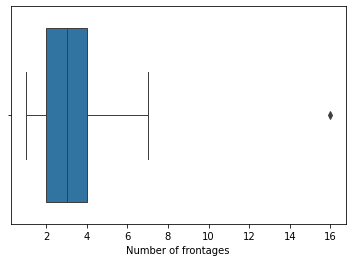

In [111]:
sns.boxplot(x='Number of frontages', data=df, width=0.8, linewidth=1)

In [112]:
df[df['Number of frontages'] > 4]

,Immoweb ID,Price,Building condition,Kitchen type,Bedrooms,Furnished,Number of frontages,Swimming pool,Surface of the plot,Living area,...,City_Tielt,City_Tongeren,City_Tournai,City_Turnhout,City_Verviers,City_Veurne,City_Virton,City_Waremme,Terrace_Combined,garden_label
4874,9723884,495000.0,4.0,1.0,4,0,6,0,1070.0,262.0,...,0,0,0,0,0,0,0,0,1.0,1
4950,9660246,875000.0,4.0,1.0,8,0,6,0,32161.0,678.0,...,0,0,0,0,0,0,0,0,1.0,1
5255,9726549,575000.0,6.0,1.0,3,0,6,1,1200.0,150.0,...,0,0,0,0,0,0,0,0,1.0,1
5256,9713345,98000.0,5.0,0.0,1,1,6,0,448.0,48.0,...,0,0,0,0,0,0,0,0,0.0,1
7003,9611825,550000.0,6.0,1.0,3,0,5,1,1980.0,370.0,...,0,0,0,0,0,0,0,0,1.0,1
7734,9718705,419000.0,2.0,0.0,4,0,6,0,658.0,272.0,...,0,0,0,0,0,0,0,0,0.0,1
8998,9560405,3300000.0,6.0,0.0,4,0,16,1,6700.0,150.0,...,0,0,0,0,0,0,0,0,0.0,0
9314,9722106,715000.0,2.0,0.0,6,0,6,0,1670.0,397.0,...,0,0,0,0,0,0,0,0,1.0,1
9576,9627226,1495000.0,2.0,1.0,5,0,7,1,1500.0,450.0,...,0,0,0,0,0,0,0,0,1.0,1
11725,9645024,249000.0,4.0,0.0,6,0,7,0,0.0,170.0,...,0,0,0,0,0,0,0,0,1.0,0


#### Drop all properties with Number of frontages more than 4

In [113]:
df.drop(df[df['Number of frontages'] > 4].index, inplace = True)

df

,Immoweb ID,Price,Building condition,Kitchen type,Bedrooms,Furnished,Number of frontages,Swimming pool,Surface of the plot,Living area,...,City_Tielt,City_Tongeren,City_Tournai,City_Turnhout,City_Verviers,City_Veurne,City_Virton,City_Waremme,Terrace_Combined,garden_label
0,9729720,179000.0,4.0,1.0,1,1,3,1,0.0,63.0,...,0,0,0,0,0,0,0,0,1.0,0
1,9729785,255000.0,4.0,1.0,1,1,2,1,0.0,42.0,...,0,0,0,0,0,0,0,0,1.0,0
2,9729784,255000.0,4.0,1.0,1,1,2,1,0.0,42.0,...,0,0,0,0,0,0,0,0,1.0,0
3,9729780,620000.0,4.0,1.0,3,1,2,1,0.0,150.0,...,0,0,0,0,0,0,0,0,1.0,0
4,9727201,379000.0,4.0,2.0,2,0,3,0,0.0,120.0,...,0,0,0,0,0,0,0,0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14535,9463953,204760.0,2.0,0.0,1,0,3,1,0.0,95.0,...,0,0,0,0,0,0,0,0,0.0,0
14536,7770552,132000.0,6.0,0.0,1,0,3,1,0.0,95.0,...,0,0,0,0,0,0,0,0,0.0,0
14537,7770553,177000.0,6.0,0.0,1,0,3,1,0.0,95.0,...,0,0,0,0,0,0,0,0,1.0,0
14538,7770551,190000.0,6.0,0.0,2,0,3,1,0.0,95.0,...,0,0,0,0,0,0,0,0,1.0,0


### Surface of plot

#### Boxplot

<AxesSubplot:xlabel='Surface of the plot'>

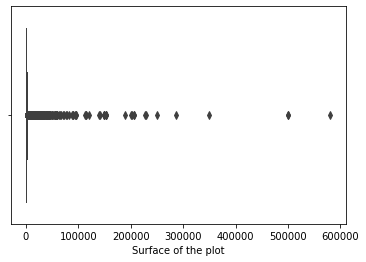

In [114]:
sns.boxplot(x='Surface of the plot', data=df, width=0.8, linewidth=1)

In [115]:
df[df['Surface of the plot'] > 100000]

,Immoweb ID,Price,Building condition,Kitchen type,Bedrooms,Furnished,Number of frontages,Swimming pool,Surface of the plot,Living area,...,City_Tielt,City_Tongeren,City_Tournai,City_Turnhout,City_Verviers,City_Veurne,City_Virton,City_Waremme,Terrace_Combined,garden_label
4938,9705229,1495000.0,2.0,0.0,4,0,4,1,119700.0,850.0,...,0,0,0,0,0,0,0,0,0.0,0
6264,9617005,5500000.0,6.0,2.0,14,0,4,0,206200.0,2300.0,...,0,0,0,0,0,0,0,0,1.0,1
6265,9219731,9500000.0,6.0,1.0,12,0,4,1,500000.0,1100.0,...,0,0,0,0,0,0,0,0,1.0,0
6268,9641474,5500000.0,4.0,1.0,14,0,4,1,206263.0,2300.0,...,0,0,0,0,0,0,0,0,1.0,0
6269,9409948,3950000.0,6.0,2.0,14,0,4,0,153030.0,1240.0,...,0,0,0,0,0,0,0,0,1.0,1
6270,9422665,3950000.0,6.0,2.0,14,0,4,0,153030.0,1240.0,...,0,0,0,0,0,0,0,0,1.0,1
6271,9422666,3950000.0,6.0,2.0,14,0,4,0,153030.0,1240.0,...,0,0,0,0,0,0,0,0,1.0,1
6274,9349668,9500000.0,4.0,2.0,7,0,4,1,500000.0,1100.0,...,0,0,0,0,0,0,0,0,0.0,0
6276,9397963,4950000.0,2.0,1.0,5,0,4,1,148400.0,1079.0,...,0,0,0,0,0,0,0,0,1.0,0
6280,9394340,4950000.0,2.0,2.0,5,0,4,1,148400.0,1079.0,...,0,0,0,0,0,0,0,0,1.0,0


#### Drop all properties with Surface of the plot more than 100000

In [116]:
df.drop(df[df['Surface of the plot'] > 100000].index, inplace = True)

df

,Immoweb ID,Price,Building condition,Kitchen type,Bedrooms,Furnished,Number of frontages,Swimming pool,Surface of the plot,Living area,...,City_Tielt,City_Tongeren,City_Tournai,City_Turnhout,City_Verviers,City_Veurne,City_Virton,City_Waremme,Terrace_Combined,garden_label
0,9729720,179000.0,4.0,1.0,1,1,3,1,0.0,63.0,...,0,0,0,0,0,0,0,0,1.0,0
1,9729785,255000.0,4.0,1.0,1,1,2,1,0.0,42.0,...,0,0,0,0,0,0,0,0,1.0,0
2,9729784,255000.0,4.0,1.0,1,1,2,1,0.0,42.0,...,0,0,0,0,0,0,0,0,1.0,0
3,9729780,620000.0,4.0,1.0,3,1,2,1,0.0,150.0,...,0,0,0,0,0,0,0,0,1.0,0
4,9727201,379000.0,4.0,2.0,2,0,3,0,0.0,120.0,...,0,0,0,0,0,0,0,0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14535,9463953,204760.0,2.0,0.0,1,0,3,1,0.0,95.0,...,0,0,0,0,0,0,0,0,0.0,0
14536,7770552,132000.0,6.0,0.0,1,0,3,1,0.0,95.0,...,0,0,0,0,0,0,0,0,0.0,0
14537,7770553,177000.0,6.0,0.0,1,0,3,1,0.0,95.0,...,0,0,0,0,0,0,0,0,1.0,0
14538,7770551,190000.0,6.0,0.0,2,0,3,1,0.0,95.0,...,0,0,0,0,0,0,0,0,1.0,0


### Price

#### Boxplot

<AxesSubplot:xlabel='Price'>

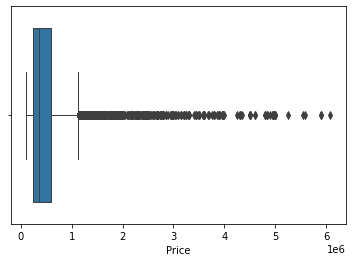

In [121]:
sns.boxplot(x='Price', data=df, width=0.8, linewidth=1)

In [122]:
df[df['Price'] < 100000]

,Immoweb ID,Price,Building condition,Kitchen type,Bedrooms,Furnished,Number of frontages,Swimming pool,Surface of the plot,Living area,...,City_Tielt,City_Tongeren,City_Tournai,City_Turnhout,City_Verviers,City_Veurne,City_Virton,City_Waremme,Terrace_Combined,garden_label


#### Drop all properties with Price less than 100000

In [120]:
df.drop(df[df['Price'] < 100000].index, inplace = True)

df

,Immoweb ID,Price,Building condition,Kitchen type,Bedrooms,Furnished,Number of frontages,Swimming pool,Surface of the plot,Living area,...,City_Tielt,City_Tongeren,City_Tournai,City_Turnhout,City_Verviers,City_Veurne,City_Virton,City_Waremme,Terrace_Combined,garden_label
0,9729720,179000.0,4.0,1.0,1,1,3,1,0.0,63.0,...,0,0,0,0,0,0,0,0,1.0,0
1,9729785,255000.0,4.0,1.0,1,1,2,1,0.0,42.0,...,0,0,0,0,0,0,0,0,1.0,0
2,9729784,255000.0,4.0,1.0,1,1,2,1,0.0,42.0,...,0,0,0,0,0,0,0,0,1.0,0
3,9729780,620000.0,4.0,1.0,3,1,2,1,0.0,150.0,...,0,0,0,0,0,0,0,0,1.0,0
4,9727201,379000.0,4.0,2.0,2,0,3,0,0.0,120.0,...,0,0,0,0,0,0,0,0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14535,9463953,204760.0,2.0,0.0,1,0,3,1,0.0,95.0,...,0,0,0,0,0,0,0,0,0.0,0
14536,7770552,132000.0,6.0,0.0,1,0,3,1,0.0,95.0,...,0,0,0,0,0,0,0,0,0.0,0
14537,7770553,177000.0,6.0,0.0,1,0,3,1,0.0,95.0,...,0,0,0,0,0,0,0,0,1.0,0
14538,7770551,190000.0,6.0,0.0,2,0,3,1,0.0,95.0,...,0,0,0,0,0,0,0,0,1.0,0


### Create a CSV File

In [123]:
df.to_csv('data/clean_data.csv', index=False)